In [36]:
import requests
from IPython.display import display
import pandas as pd
import numpy as np
import nltk
import pickle
import warnings

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup as bso

page = requests.get('https://ejournal.unsrat.ac.id/index.php/informatika/issue/archive')
soup = bso(page.text, 'html.parser')
journal_title = soup.find_all('div', class_='tocTitle')
j_issues = soup.find_all('h4')

j_title = []
link_pdf = []
j_abstrak = []
j_keyword = []
archive_link = []

#mengambil link tiap issue/volume
for container in j_issues:
    link_arc = container.a.get('href')
    archive_link.append(link_arc)

#mengambil judul dan link abstrak dari volume
for i in archive_link:
    pageis = requests.get(i)
    soup = bso(pageis.text, 'html.parser')
    find_list = soup.find_all('div', class_='tocTitle')    
    for container in find_list:  
        name = container.a.text
        j_title.append(name)
        link_list = container.a.get('href')
        link_pdf.append(link_list)
        
#mengambil abstrak tiap judul
for i in link_pdf:
    pages = requests.get(i)
    soupss = bso(pages.text,'html.parser')
    abstrak = soupss.find('div', {'id':'articleAbstract'})
    abstrak_clean = abstrak.text
    j_abstrak.append(abstrak_clean)

#mengambil keyword tiap judul
for i in link_pdf:
    pageskey = requests.get(i)
    soupskey = bso(pageskey.text,'html.parser')
    keyword = soupskey.find('div', {'id':'articleSubject'})
    if keyword:
        j_keyword.append(keyword.div.text)
    else:
        j_keyword.append(" ")

#membuat dataframe training data
key_new = pd.DataFrame({
    'Judul': j_title,
    'Abstrak' : j_abstrak,
    'Keyword' : j_keyword,
})

# Tunggu kernel idle sebelum lanjut Cell berikutnya

# Hasil dataframe key_new masih akan diproses manual, karena tidak semua keyword ada dalam bagian articleSubject di halaman html e-journal UNSRAT

# Terdapat pula beberapa jurnal yang tidak mempunyai keyword pada halaman e-journal, jurnal tanpa keyword tersebut tidak akan digunakan dalam pembuatan model prediksi

# Hasil dataframe key_new yang telah diproses manual akan disimpan dalam bentuk file csv dengan nama Key623.CSV

In [58]:
key_new.to_csv("Key623.csv")

In [4]:
import re
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

def stopword_eng(text):
    stop_words = set(stopwords.words('english'))
    text = [w for w in text.split() if not w in stop_words]
    return ' '.join(text)

#menghilangkan kata-kata yang tidak penting
def stopword_ina(text):
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    stopword = factory.create_stop_word_remover()
    text = stopword.remove(text)
    return text

#menghilangkan imbuhan pada kata berimbuhan
def stemming_ina(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    return(text)

def pre_process(text):
    text = clean_text(text)
    text = stopword_eng(text)
    text = stopword_ina(text)
    #text = stemming_ina(text)
    return text

In [6]:
key_new = pd.read_csv('Key623.csv', index_col = 0)
key_new['abstrak_besih'] = key_new['Abstrak'].apply(lambda x: clean_text(x))
key_new['abstrak_besih'] = key_new['Abstrak'].apply(lambda x: stopword_eng(x))
key_new['abstrak_besih'] = key_new['Abstrak'].apply(lambda x: stopword_ina(x))
#key_new['abstrak_besih'] = key_new['Abstrak'].apply(lambda x: stemming_ina(x))

In [27]:
key_new = pd.read_csv('Key623.csv', index_col = 0)
key_new['Keyword'] = key_new['Keyword'].apply(lambda x: x.replace("'",''))
key_new['Keyword'] = key_new['Keyword'].apply(lambda x: x.replace("]",''))
key_new['Keyword'] = key_new['Keyword'].apply(lambda x: x.replace("[",''))
key_new['Keyword'] = key_new['Keyword'].apply(lambda x: x.replace(", ",','))
key_new['Keyword'] = key_new['Keyword'].apply(lambda x: str(x).split(","))
all_key = sum(key_new['Keyword'],[])

print("Total Artikel Ilmiah :",len(key_new['Judul']))

Total Artikel Ilmiah : 221


In [11]:
print("Total Keyword :",len(set(all_key)))

Total Keyword : 623


In [26]:
all_key = sum(key_new['Keyword'],[])
print("Total Unique Keyword :",len(set(all_key)))
#(set(all_key))

Total Unique Keyword : 623


In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

unique, counts = np.unique(key_new['Keyword'], return_counts=True)

#label space tiap instance
#display(np.asarray((unique, counts)).T)

In [16]:
key_new.head()

,Judul,Abstrak,Keyword,abstrak_bersih
1,pemanfaatan plaform pemrograman daring dalam p...,"\nabstract\n\nsejak akhir tahun 2019, dunia me...","[blended learning, flipped classroom, covid-19...",sejak akhir tahun dunia hp ancam buah virus b...
2,design architecture of jembrana e-government ...,\nabstract\n\nabstract — e-government (e-gov) ...,"[e-government, teknologi informasi, rencana, p...",e government e gov use information technolog...
3,rancang bangun aplikasi digital library univer...,\nabstract\n\nabstrak — perpustakaan merupakan...,"[perpustakaan, aplikasi, website, software dev...",pustaka rupa sarana mahasiswa ajar cari info...
5,computer forensics and cyber crime handling,\nabstract\n\nabstract - computer forensics is...,"[computer forensic, crm, cyber crime, search a...",computer forensics science identifying extra...
6,decision support system for covid-19 aid recip...,\nabstract\n\nabstract — covid19 is a disease ...,"[covid19, dss, sistem pendukung keputusan, vikor]",covid disease caused corona virus world heal...


[Text(0, 0.5, 'Keyword'), Text(0.5, 0, 'Total Keyword')]

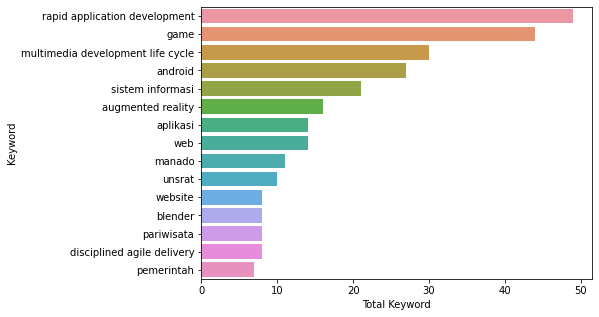

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

all_key = nltk.FreqDist(all_key)
newdf = pd.DataFrame({'Keyword': list(all_key.keys()), 'Count': list(all_key.values())})

g = newdf.nlargest(columns="Count", n = 15) 
plt.figure(figsize=(7,5))
ax = sns.barplot(data=g, x= "Count", y = "Keyword")
ax.set(ylabel = 'Keyword', xlabel = 'Total Keyword')

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(key_new['Keyword'])

y = multilabel_binarizer.transform(key_new['Keyword'])

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features = 50)
xtrain, xval, ytrain, yval = train_test_split(key_new['abstrak_bersih'], y, test_size=0.2, random_state=9)

In [33]:
tf = TfidfVectorizer(max_df = 0.8, max_features = 50)
xtrain_tfidf = tf.fit_transform(xtrain)
name=tf.get_feature_names()


#display(tf.vocabulary_)
df = pd.DataFrame(xtrain_tfidf.toarray(), columns = name, index = None)
df.head()
#xtrain_tfidf.get_shape()

,ajar,anak,android,aplikasi,application,banyak,bas,based,buat,dapat,data,development,game,hasil,indonesia,informasi,information,jadi,kembang,kenal,kota,laku,learning,lebih,life,manado,masyarakat,media,method,metode,minahasa,mudah,multimedia,proses,reality,rupa,salah,satu,sebut,sistem,suatu,sulawesi,system,tahap,tahu,teknologi,teliti,tuju,using,web
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.067582,0.0,0.479112,0.624902,0.000000,0.000000,0.0,0.115446,0.081563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089980,0.062736,0.545756,0.000000,0.000000,0.0,0.0,0.075525,0.000000,0.000000,0.000000,0.084611,0.000000,0.000000,0.104213,0.000000,0.000000,0.079832,0.000000,0.077625,0.096935,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.138704,0.185129,0.262856,0.0,0.105906,0.000000,0.096702,0.0,0.195874,0.255477,0.233417,0.105202,0.0,0.000000,0.000000,0.000000,0.128752,0.000000,0.000000,0.128752,0.132980,0.000000,0.000000,0.000000,0.126741,0.660766,0.0,0.0,0.108069,0.113426,0.111074,0.127738,0.000000,0.000000,0.000000,0.000000,0.277407,0.000000,0.114231,0.096702,0.111074,0.138704,0.0
2,0.000000,0.000000,0.0,0.000000,0.286335,0.000000,0.077219,0.083848,0.000000,0.000000,0.0,0.320107,0.000000,0.116915,0.0,0.236815,0.308876,0.000000,0.063596,0.0,0.000000,0.000000,0.000000,0.077832,0.000000,0.000000,0.077832,0.160776,0.077832,0.054266,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.292751,0.082425,0.592604,0.360573,0.000000,0.000000,0.069054,0.058458,0.067145,0.000000,0.0
3,0.178155,0.058864,0.0,0.117369,0.071408,0.081533,0.000000,0.000000,0.167457,0.052836,0.0,0.000000,0.920389,0.000000,0.0,0.000000,0.000000,0.070378,0.000000,0.0,0.000000,0.035189,0.101894,0.000000,0.000000,0.098525,0.077641,0.000000,0.038820,0.054133,0.000000,0.038214,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.077030,0.000000,0.000000,0.000000,0.000000,0.000000,0.123335,0.000000,0.029157,0.033490,0.000000,0.0
4,0.395515,0.000000,0.0,0.195425,0.158531,0.090505,0.000000,0.000000,0.000000,0.000000,0.0,0.283566,0.000000,0.064731,0.0,0.000000,0.000000,0.078122,0.000000,0.0,0.000000,0.000000,0.452423,0.000000,0.442303,0.000000,0.000000,0.089014,0.172368,0.180268,0.000000,0.000000,0.442303,0.0,0.0,0.072339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076464,0.064731,0.000000,0.000000,0.0


In [37]:
#BR-OvA
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import warnings

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

with warnings.catch_warnings(record=True) as warn:
    clf.fit(xtrain_tfidf, ytrain)
    y_pred = clf.predict(xval_tfidf)

In [87]:
multilabel_binarizer.inverse_transform(y_pred)
#clf.multilabel_
#display(len(warn))

[('game',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('game',),
 ()]

In [38]:
#BR-SVM
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# transform target variable
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'linear'],
    },
]

with warnings.catch_warnings(record=True) as warn:
    clf_br_svm = GridSearchCV(BinaryRelevance(), parameters, scoring='accuracy')
    clf_br_svm.fit(xtrain_tfidf, ytrain)
    y_pred_br = clf_br_svm.predict(xval_tfidf)

In [114]:
multilabel_binarizer.inverse_transform(y_pred_br)

[('game',),
 (),
 (),
 (),
 ('multimedia development life cycle',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('game',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('multimedia development life cycle',),
 (),
 ('game',),
 ()]

In [39]:
#MLkNN
from skmultilearn.adapt import MLkNN

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(key_new['Keyword'])

# transform target variable
y = multilabel_binarizer.transform(key_new['Keyword'])
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

with warnings.catch_warnings(record=True) as warn:
    clf_mlknn = MLkNN(k=3)
    clf_mlknn.fit(xtrain_tfidf, ytrain)
    y_pred_mlknn = clf_mlknn.predict(xval_tfidf)

In [92]:
multilabel_binarizer.inverse_transform(y_pred_mlknn)

[('game',),
 ('android',),
 (),
 (),
 ('augmented reality', 'multimedia development life cycle'),
 (),
 ('rapid application development',),
 (),
 (),
 (),
 ('android',),
 (),
 (),
 (),
 ('aplikasi',),
 (),
 ('game',),
 (),
 ('android', 'rapid application development'),
 ('android', 'rapid application development'),
 (),
 (),
 (),
 (),
 (),
 ('android',),
 ('android', 'rapid application development'),
 (),
 (),
 ('android',),
 (),
 ('entrepreneurship', 'game'),
 (),
 ('manado',),
 ('multimedia development life cycle',),
 (),
 ('addie', 'e-learning'),
 (),
 (),
 ('rapid application development',),
 (),
 ('multimedia development life cycle',),
 (),
 ('game',),
 ('android', 'aplikasi', 'rapid application development')]

In [40]:
from skmultilearn.adapt import BRkNNaClassifier

#Metode BRkNNaClassifier
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

clf_brknn = BRkNNaClassifier(k=3)
clf_brknn.fit(xtrain_tfidf, ytrain)
y_pred_brknn = clf_brknn.predict(xval_tfidf)

C:\Users\62896\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [116]:
multilabel_binarizer.inverse_transform(y_pred_brknn)

[('game',),
 ('android',),
 (),
 (),
 ('augmented reality', 'multimedia development life cycle'),
 (),
 ('rapid application development',),
 (),
 (),
 (),
 ('android',),
 (),
 (),
 ('data mining',),
 ('aplikasi',),
 (),
 ('game',),
 (),
 ('android', 'rapid application development'),
 ('android', 'rapid application development'),
 (),
 ('manado',),
 (),
 (),
 (),
 ('android',),
 ('android', 'rapid application development'),
 ('manado',),
 (),
 ('android',),
 ('php', 'sistem informasi'),
 ('entrepreneurship', 'game'),
 (),
 ('manado', 'pemerintah'),
 ('blender', 'multimedia development life cycle'),
 (),
 ('addie', 'e-learning'),
 (),
 (),
 ('rapid application development',),
 (),
 ('multimedia development life cycle',),
 ('sistem informasi',),
 ('game',),
 ('android', 'aplikasi', 'rapid application development')]

In [52]:
import joblib
import pickle

pickle.dump(xtrain, open('xtrain.sav', 'wb'))
pickle.dump(multilabel_binarizer, open('multilabel_binarizer.sav','wb'))
joblib.dump(clf, 'model_br_ova.pkl')
joblib.dump(clf_br_svm, 'model_br_svm.pkl')
joblib.dump(clf_mlknn, 'model_mlknn.pkl')
joblib.dump(clf_brknn, 'model_brknn.pkl')

In [42]:
import joblib

multilabel_binarizer = pickle.load(open("multilabel_binarizer.sav", 'rb'))
xtrain = pickle.load(open("xtrain.sav", 'rb'))
model_brknn1 = joblib.load('model_brknn.pkl')
model_mlknn1 = joblib.load('model_mlknn.pkl')
model_br_svm1 = joblib.load('model_br_svm.pkl')
model_br_ova1 = joblib.load('model_br_ova.pkl')

def model_brknn(q):    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features = 50)
    tfidf_vectorizer.fit_transform(xtrain)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = model_brknn1.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

def model_mlknn(q):    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features = 50)
    tfidf_vectorizer.fit_transform(xtrain)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = model_mlknn1.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

def model_br_svm(q):    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features = 50)
    tfidf_vectorizer.fit_transform(xtrain)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = model_br_svm1.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

def model_br_ova(q):    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features = 50)
    tfidf_vectorizer.fit_transform(xtrain)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = model_br_ova1.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [44]:
for i in range(5):
    k = xval.sample(3).index[0]
    print("Judul: ", key_new['Judul'][k], "\nPrediksi Keyword: ", model_brknn(xval[k]),), print("Keyword Sebenarnya : ",key_new['Keyword'][k], "\n")

Judul:  pengukuran tingkat keselarasan tata kelola teknologi informasi menggunakan cobit 5 pada pemerintah sulawesi utara 
Prediksi Keyword:  [()]
Keyword Sebenarnya :  ['cobit 5', 'keselarasan ti', 'tata kelola ti'] 

Judul:  perancangan sistem informasi manajemen rumah sakit berbasis web 
Prediksi Keyword:  [()]
Keyword Sebenarnya :  ['rumah sakit', 'sistem informasi manajemen', 'waterfall', 'web'] 

Judul:  aplikasi monitoring ktp kota manado dengan menggunakan sms gateway 
Prediksi Keyword:  [()]
Keyword Sebenarnya :  ['ktp', 'sms gateway', 'rapid application development', 'gammu', 'php'] 

Judul:  virtual tour sebagai media promosi interaktif penginapan di kepulauan bunaken 
Prediksi Keyword:  [()]
Keyword Sebenarnya :  ['interaktif', 'virtual tour 360⁰', 'cottage-cottage', 'promosi', 'virtual tour'] 

Judul:  virtual tour sebagai media promosi interaktif penginapan di kepulauan bunaken 
Prediksi Keyword:  [()]
Keyword Sebenarnya :  ['interaktif', 'virtual tour 360⁰', 'cottage-cot

In [97]:
import pandas as pd

y1=multilabel_binarizer.inverse_transform(y_pred)#Binary Relevance dengan OvA
y2=multilabel_binarizer.inverse_transform(y_pred_br)#Binary Relevance dengan SVM
y3=multilabel_binarizer.inverse_transform(y_pred_brknn)#Binary Relevance k Nearest Neighbor
y4=multilabel_binarizer.inverse_transform(y_pred_mlknn)#Multi k Nearest Neighbor

data={'BR-OvA':y1,'BR-SVM':y2,'BRkNN':y3,'MLkNN':y4}
pd.DataFrame(data)

,BR-OvA,BR-SVM,BRkNN,MLkNN
0,"(game,)","(game,)","(game,)","(game,)"
1,(),(),"(android,)","(android,)"
2,(),(),(),()
3,(),(),(),()
4,(),"(multimedia development life cycle,)","(augmented reality, multimedia development lif...","(augmented reality, multimedia development lif..."
5,(),(),(),()
6,(),(),"(rapid application development,)","(rapid application development,)"
7,(),(),(),()
8,(),(),(),()
9,(),(),(),()


In [98]:
import numpy as np

def alpha_evaluation_score(y_true, y_pred):
    alpha = 1
    beta = 0.25
    gamma = 1
    tp = np.sum(np.logical_and(y_true, y_pred))#Menghitung True Positives pada model prediksi
    fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))#Menghitung False Positives pada model prediksi
    fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))#Menghitung False Negatives pada model prediksi
    
    alpha_score = (1 - ((beta * fn + gamma * fp ) / (tp + fn + fp + 0.0001)))**alpha #Menghitung alpha evaluation score
    return alpha_score

ypred_br = y_pred_br.A
ypred_brknn = y_pred_brknn.A
ypred_mlknn = y_pred_mlknn.A

a11 = alpha_evaluation_score(y_true=yval, y_pred = y_pred)
a21 = alpha_evaluation_score(y_true=yval, y_pred = ypred_br)
a31 = alpha_evaluation_score(y_true=yval, y_pred = ypred_brknn)
a41 = alpha_evaluation_score(y_true=yval, y_pred = ypred_mlknn)

print("Alpha Evaluation Score untuk Binary Relevance OvA :", a11,
      "\nAlpha Evaluation Score untuk Binary Relevance SVM :",a21,
      "\nAlpha Evaluation Score untuk Binary Relevance kNN :",a31,
      "\nAlpha Evaluation Score untuk Multi-label kNN      :",a41)

Alpha Evaluation Score untuk Binary Relevance OvA : 0.7524273046469395 
Alpha Evaluation Score untuk Binary Relevance SVM : 0.7560680795786021 
Alpha Evaluation Score untuk Binary Relevance kNN : 0.7098215581153758 
Alpha Evaluation Score untuk Multi-label kNN      : 0.7315669439783669


In [102]:
from sklearn.metrics import jaccard_score

js1 = jaccard_score(yval, y_pred, average='micro')
js2 = jaccard_score(yval, ypred_br, average='micro')
js3 = jaccard_score(yval, ypred_brknn, average='micro')
js4 = jaccard_score(yval, ypred_mlknn, average='micro')

#f1_score(yval, y_pred_br, average='weighted')
print("jaccard similarity Binary Relevance dengan OvA        :",js1,
      "\njaccard similarity Relevance dengan SVM               :",js2,
      "\njaccard similarity Binary Relevance k Nearest Neighbor:",js3,
      "\njaccard similarity Multi-label k Nearest Neighbor     :",js4)


jaccard similarity Binary Relevance dengan OvA        : 0.009708737864077669 
jaccard similarity Relevance dengan SVM               : 0.024271844660194174 
jaccard similarity Binary Relevance k Nearest Neighbor: 0.08035714285714286 
jaccard similarity Multi-label k Nearest Neighbor     : 0.07834101382488479


In [103]:
from sklearn.metrics import precision_score

ps1 = precision_score(yval, y_pred, average='samples')
ps2 = precision_score(yval, ypred_br, average='samples')
ps3 = precision_score(yval, ypred_brknn, average='samples')
ps4 = precision_score(yval, ypred_mlknn, average='samples')

#f1_score(yval, y_pred_br, average='weighted')
print("precision score Binary Relevance dengan OvA        :",ps1,
      "\nprecision score Relevance dengan SVM               :",ps2,
      "\nprecision score Binary Relevance k Nearest Neighbor:",ps3,
      "\nprecision score Multi-label k Nearest Neighbor     :",ps4)


precision score Binary Relevance dengan OvA        : 0.044444444444444446 
precision score Relevance dengan SVM               : 0.1111111111111111 
precision score Binary Relevance k Nearest Neighbor: 0.3037037037037037 
precision score Multi-label k Nearest Neighbor     : 0.29259259259259257


C:\Users\62896\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
from sklearn.metrics import recall_score
rs1 = recall_score(yval, y_pred, average='samples')
rs2 = recall_score(yval, ypred_br, average='samples')
rs3 = recall_score(yval, ypred_brknn, average='samples')
rs4 = recall_score(yval, ypred_mlknn, average='samples')

#f1_score(yval, y_pred_br, average='weighted')
print("recall score Binary Relevance dengan OvA        :",rs1,
      "\nrecall score Relevance dengan SVM               :",rs2,
      "\nrecall score Binary Relevance k Nearest Neighbor:",rs3,
      "\nrecall score Multi-label k Nearest Neighbor     :",rs4)


recall score Binary Relevance dengan OvA        : 0.011111111111111112 
recall score Relevance dengan SVM               : 0.025396825396825397 
recall score Binary Relevance k Nearest Neighbor: 0.09116402116402116 
recall score Multi-label k Nearest Neighbor     : 0.08746031746031746


In [105]:
from sklearn.metrics import f1_score
fs1 = f1_score(yval, y_pred, average='samples')
fs2 = f1_score(yval, ypred_br, average='samples')
fs3 = f1_score(yval, ypred_brknn, average='samples')
fs4 = f1_score(yval, ypred_mlknn, average='samples')

#f1_score(yval, y_pred_br, average='weighted')
print("f1-measure Binary Relevance dengan OvA        :",fs1,
      "\nf1-measure Relevance dengan SVM               :",fs2,
      "\nf1-measure Binary Relevance k Nearest Neighbor:",fs3,
      "\nf1-measure Multi-label k Nearest Neighbor     :",fs4)

f1-measure Binary Relevance dengan OvA        : 0.01746031746031746 
f1-measure Relevance dengan SVM               : 0.0407936507936508 
f1-measure Binary Relevance k Nearest Neighbor: 0.13451499118165786 
f1-measure Multi-label k Nearest Neighbor     : 0.12922398589065257


In [64]:
tp1 = np.sum(np.logical_and(yval, ypred_brknn))
fn1 = np.sum(np.logical_and(yval, np.logical_not(ypred_brknn)))

tp2 = np.sum(np.logical_and(yval, y_pred))
fn2 = np.sum(np.logical_and(yval, np.logical_not(y_pred)))

recall_brknn = 1/(tp1+fn1)*a41
recall_br = 1/(tp2+fn2)*a21
print("brknn",recall_brknn, 
      "\nbr",recall_br)

brknn 0.0035512958445551787 
br 0.0036702333960126313


In [123]:
import PyPDF2
mypdf1 = open("28087-57698-1-SM.pdf", mode='rb')
pdf_document1 = PyPDF2.PdfFileReader(mypdf1)
f_page1 = pdf_document1.getPage(0)
text1 = f_page1.extractText()
text2 = pre_process(text1)
print(text2)

jurnal teknik informatika vol iss n abstract transportasi merupakan sarana sangat dibutuhkan zaman sekarang adany transportasi mengefektifkan pekerjaan emenuhi kebutuhan sehari hari transportasi baik mencerminkan keteraturan kota baik hal ni disebabkan transportasi merupakan suatu alat bantu mengarahkan pembangunan daerah perkotaan itu transportasi merupakan suatu prasarana ba gi pergerakan manusia barang timbul akibat danya kegiatan daerah perkotaan penelitian p enulis mengangkat masalah analisa tingkat kepuasan pengguna aplikasi transportasi online kota manad hasil diperoleh mana tingkat kepuasan masya rakat aplikasi transportasi online gojek gre b rata rata memiliki nilai items gojek grab ems gojek grab items gojek grab items gojek grab items gojek grab items gojek grab items gojek greb items gojek grab items gojek grab items gojek grab items gojek grab items gojek grab kata kunci analisa aplikasi trasportasi online kota manado abstract transportation tool much needed today existenc

In [51]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features = 50)
tfidf_vectorizer.fit_transform(xtrain)
q_vec = tfidf_vectorizer.transform([text2])

name=tfidf_vectorizer.get_feature_names()

#display(tf.vocabulary_)
df = pd.DataFrame(q_vec.toarray(), columns = name)
display(df)

,ajar,anak,android,aplikasi,application,banyak,bas,based,buat,dapat,data,development,game,hasil,indonesia,informasi,information,jadi,kembang,kenal,kota,laku,learning,lebih,life,manado,masyarakat,media,method,metode,minahasa,mudah,multimedia,proses,reality,rupa,salah,satu,sebut,sistem,suatu,sulawesi,system,tahap,tahu,teknologi,teliti,tuju,using,web
0,0.0,0.0,0.527188,0.149994,0.136887,0.052099,0.0,0.106892,0.0,0.033762,0.052539,0.040808,0.0,0.037262,0.0,0.0,0.0,0.0,0.0,0.0,0.381915,0.0,0.0,0.0,0.0,0.566605,0.148834,0.0,0.049611,0.03459,0.0,0.0,0.0,0.160338,0.0,0.0,0.0,0.0,0.0,0.279907,0.052539,0.0,0.172377,0.053446,0.0,0.044016,0.0,0.0,0.160338,0.0
